In [1]:
import glob
import os
import time
import math
import hashlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import optuna
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import math
import imageio
from PIL import Image

In [2]:
# For Jojie
DATASET_DIR = Path('/mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets')
CACHE_DIR = Path('/mnt/processed/private/msds2025/cpt3/ml3/finalproject/cache')
WEIGHTS_DIR = Path('/mnt/processed/private/msds2025/cpt3/ml3/finalproject/weights')
OUTPUT_DIR = Path('/mnt/processed/private/msds2025/cpt3/ml3/finalproject/output')

# For Local Development
# DATASET_DIR = Path("datasets/")
# CACHE_DIR = Path("cache/")
# WEIGHTS_DIR = Path("weights/")
# OUTPUT_DIR = Path("output/")

DATASET_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

CITY_NAMES = [
    "Caloocan City",
    "Las Piñas",
    "Makati City",
    "Malabon",
    "Mandaluyong City",
    "Manila",
    "Marikina", # Data not Available
    "Muntinlupa", # Data not Available
    "Navotas",
    "Paranaque City",
    "Pasay", # Data not Available
    "Pasig",
    "Pateros", # Data not Available
    "Quezon City",
    "San Juan",
    "Taguig",
    "Valenzuela",
]

POLLUTANT_COLUMNS = [
    "components.co", "components.no", "components.no2", "components.o3",
    "components.so2", "components.pm2_5", "components.pm10"
]

In [3]:
dfs = []
for file in glob.glob(str(DATASET_DIR / "aqi" / "*" / "*.csv")):
    print(f"Reading {file}")
    df = pd.read_csv(file)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2025/202502_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2025/202503_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2025/202501_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2024/202405_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2024/202411_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2024/202401_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2024/202404_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2024/202410_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/datasets/aqi/2024/202407_CombinedData.csv
Reading /mnt/processed/private/msds2025/cpt3/ml3/finalproject/da

In [4]:
df = df[df['city_name'].isin(CITY_NAMES)]
df = df[["datetime","components.co","components.no","components.no2","components.o3","components.so2","components.pm2_5","components.pm10","components.nh3","city_name"]]
df.sort_values(by=['city_name', 'datetime'], inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.round('h')
# df.set_index('datetime', inplace=True)
# df['datetime'] = df['datetime'].round('h')

In [5]:
filled_dfs = []
for city, group in tqdm(df.groupby('city_name')):
    group = group.set_index('datetime')
    full_index = pd.date_range(start=group.index.min(), end=group.index.max(), freq='h')
    group = group.groupby(level=0).mean(numeric_only=True)
    group = group.reindex(full_index)
    
    group.interpolate(method='linear', inplace=True)
    group['city_name'] = city  # Re-add city name after reindex
    filled_dfs.append(group)

filled_dfs = pd.concat(filled_dfs)

100%|██████████| 13/13 [00:00<00:00, 68.31it/s]


In [6]:
city_column = filled_dfs['city_name'].copy()
dataset_df = pd.get_dummies(filled_dfs, prefix='city',dtype=np.int8)
dataset_df["city_name"] = city_column

## Calcualting Baseline for the Dataset

As a baseline, we compute the negative log-likelihood (NLL) under a single Gaussian distribution fitted to the entire training dataset. This Gaussian has a fixed mean and standard deviation equal to the empirical mean and standard deviation of the target variable. The baseline NLL represents the performance of a model that ignores all input features and simply assumes that the target values follow a constant distribution.

In [7]:
nlls = []
for city_name, group in dataset_df.groupby('city_name'):
    group = group.copy()
    y = group.drop(columns=['city_name'])[POLLUTANT_COLUMNS]
    y = torch.tensor(y.values, dtype=torch.float32)
    mu = y.mean()
    sigma = y.std()

    eps = 1e-6
    sigma = torch.clamp(sigma, min=eps)
    z = (y - mu) / sigma

    log_prob = -0.5 * 7 * math.log(2 * math.pi) - torch.sum(torch.log(sigma)) - 0.5 * torch.sum(z ** 2, dim=1)
    nll = -log_prob.mean()

    nlls.append(nll.item())

print(f"Average Negative Log Likelihood for all cities: {np.average(nlls):.4f}", )

Average Negative Log Likelihood for all cities: 15.7298


## Model Training

In [8]:
class AQIDataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step, mean, std):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.min_index = min_index
        self.max_index = min(max_index if max_index is not None else len(data) - delay - 1,
                             len(data) - delay - 1)
        self.step = step
        self.mean = mean
        self.std = std

        param_str = f"{self._data_hash()}_lb{lookback}_d{delay}_min{min_index}_max{self.max_index}_s{step}"
        samples_path = os.path.join(CACHE_DIR, f"{param_str}_samples.pt")
        targets_path = os.path.join(CACHE_DIR, f"{param_str}_targets.pt")
        metadata_path = os.path.join(CACHE_DIR, f"{param_str}_metadata.pkl")

        if all(os.path.exists(p) for p in [samples_path, targets_path, metadata_path]):
            self.samples = torch.load(samples_path)
            self.targets = torch.load(targets_path)

            with open(metadata_path, "rb") as f:
                metadata = pickle.load(f)
            self._timestamps = metadata["timestamps"]
            self.mean = metadata["mean"]
            self.std = metadata["std"]
        else:
            samples, targets, timestamps = [], [], []

            for idx in tqdm(range(self.__len__())):
                i = self.min_index + idx + self.lookback
                indices = range(i - self.lookback, i, self.step)

                sample = self.data.iloc[indices].values  # shape: (lookback, num_features)
                target_row = self.data.iloc[i + self.delay]

                target = target_row[POLLUTANT_COLUMNS].values.astype(np.float32)
                samples.append(sample)
                targets.append(target)
                timestamps.append(pd.to_datetime(target_row.name))

            self.samples = torch.tensor(np.array(samples), dtype=torch.float32)
            self.targets = torch.tensor(np.array(targets), dtype=torch.float32)
            self._timestamps = timestamps

            torch.save(self.samples, samples_path)
            torch.save(self.targets, targets_path)
            with open(metadata_path, "wb") as f:
                pickle.dump({
                    "timestamps": self._timestamps,
                    "mean": self.mean,
                    "std": self.std
                }, f)

    def _data_hash(self) -> str:
        content_hash = pd.util.hash_pandas_object(self.data, index=True).values
        combined = content_hash.tobytes()
        return hashlib.md5(combined).hexdigest()

    def __len__(self):
        return self.max_index - self.min_index - self.lookback + 1

    def __getitem__(self, index):
        return self.samples[index], self.targets[index]

    def get_metadata(self, index: int):
        normalized_target = self.targets[index].numpy()
        original_target = normalized_target * self.std + self.mean
        return {
            "timestamp": self._timestamps[index],
            "original_target": original_target,
            "mean": self.mean,
            "std": self.std,
        }
    
from torch.utils.data import ConcatDataset

class ConcatDatasetWithMetadata(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        self._offsets = self._compute_offsets()

    def _compute_offsets(self):
        offsets = []
        offset = 0
        for d in self.datasets:
            offsets.append(offset)
            offset += len(d)
        return offsets

    def get_metadata(self, index: int):
        for i in range(len(self.datasets)):
            if index < self._offsets[i] + len(self.datasets[i]):
                local_index = index - self._offsets[i]
                return self.datasets[i].get_metadata(local_index)
        raise IndexError("Index out of range for get_metadata in ConcatDatasetWithMetadata.")

In [9]:
def generate_datasets(dataset_df : pd.DataFrame, lookback=96, delay=24, step=1):
    training_datasets = []
    validation_datasets = []
    for city, group in dataset_df.groupby("city_name"):
        group.sort_index(ascending=True, inplace=True)

        last_index = group.index[-1]
        one_year_ago = last_index - pd.DateOffset(months=6)
        min_index = group.index.get_loc(one_year_ago)

        group.drop(columns=["city_name"], inplace=True)
        training_df = group.iloc[:min_index].copy()
        validation_df = group.iloc[min_index:].copy()

        training_mean = training_df[POLLUTANT_COLUMNS].mean()
        training_std = training_df[POLLUTANT_COLUMNS].std()

        training_df[POLLUTANT_COLUMNS] = (training_df[POLLUTANT_COLUMNS] - training_mean) / training_std
        validation_df[POLLUTANT_COLUMNS] = (validation_df[POLLUTANT_COLUMNS] - training_mean) / training_std

        training_dataset = AQIDataset(
            training_df,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=step,
            mean=training_mean,
            std=training_std,
        )

        validation_dataset = AQIDataset(
            validation_df,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=step,
            mean=training_mean,
            std=training_std,
        )

        training_datasets.append(training_dataset)
        validation_datasets.append(validation_dataset)

    training_dataset = ConcatDatasetWithMetadata(training_datasets)
    validation_dataset = ConcatDatasetWithMetadata(validation_datasets)

    return training_dataset, validation_dataset
    return training_datasets[0], validation_dataset[0]

### Models

we are going to compare multiple bla lba bla

In [10]:
class MDNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_mixtures, dropout=0.0):
        super(MDNLayer, self).__init__()
        self.out_dim = out_dim
        self.num_mixtures = num_mixtures

        self.dropout = nn.Dropout(dropout)

        self.fc_mu = nn.Linear(in_dim, num_mixtures * out_dim)
        self.fc_sigma = nn.Linear(in_dim, num_mixtures * out_dim)
        self.fc_alpha = nn.Linear(in_dim, num_mixtures)

    def forward(self, x):
        x = self.dropout(x)
        mu = self.fc_mu(x)
        sigma = torch.exp(self.fc_sigma(x)).clamp(min=1e-6)  # ensures strictly positive
        alpha = F.softmax(self.fc_alpha(x), dim=1)
        return mu, sigma, alpha
    
    
class LSTM_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_mixtures, output_dim, dropout=0.3):
        super(LSTM_MDN, self).__init__()
        self.num_mixtures = num_mixtures
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # last timestep

        h = self.fc(last_output)
        h = self.batch_norm(h)
        h = F.relu(h)
        h = self.dropout(h)

        mu, sigma, alpha = self.mdn(h)
        return mu, sigma, alpha

### Negative Log-Likelihood (NLL) Loss Function

Let:
- $ \mathbf{y} \in \mathbb{R}^D $ — target vector
- $ \boldsymbol{\mu}_k \in \mathbb{R}^D $ — mean vector of the $k$-th Gaussian
- $ \boldsymbol{\sigma}_k \in \mathbb{R}^D $ — standard deviation (scale) of the $k$-th Gaussian
- $ \alpha_k \in (0, 1) $ — mixture weight (prior probability) of the $k$-th Gaussian, where $ \sum_{k=1}^K \alpha_k = 1 $
- $ K $ — number of mixtures
- $ N $ — batch size

The mixture density network loss is the negative log-likelihood over a mixture of Gaussians:

$$ L_MDN = - (1 / N) * Σ_{i=1}^N log( Σ_{k=1}^K α_k^{(i)} * N(y^{(i)} | μ_k^{(i)}, σ_k^{(i)}) ) $$

Each Gaussian component with diagonal covariance is computed as:

$$ N(y | μ_k, σ_k) = Π_{d=1}^D [ 1 / sqrt(2πσ_{k,d}²) ] * exp( - (y_d - μ_{k,d})² / (2σ_{k,d}²) ) $$

Taking the logarithm of the Gaussian:

$$ log N(y | μ_k, σ_k) = - Σ_{d=1}^D [ (1/2) * log(2πσ_{k,d}²) + (y_d - μ_{k,d})² / (2σ_{k,d}²) ] $$ 

The final loss with log-sum-exp trick becomes:

$$ L_MDN = - (1 / N) * Σ_{i=1}^N log( Σ_{k=1}^K exp( log α_k^{(i)} + log N(y^{(i)} | μ_k^{(i)}, σ_k^{(i)}) ) ) $$ 

In [13]:
def mdn_loss(y, mu, sigma, alpha, num_mixtures):
    batch_size = y.size(0)
    output_dim = mu.size(1) // num_mixtures

    mu = mu.view(batch_size, num_mixtures, output_dim)
    sigma = sigma.view(batch_size, num_mixtures, output_dim)
    alpha = alpha.view(batch_size, num_mixtures)

    y = y.unsqueeze(1).expand(-1, num_mixtures, -1)
    # print(f"y shape: {y.shape}, mu shape: {mu.shape}, sigma shape: {sigma.shape}, alpha shape: {alpha.shape}")
    # print("First pollutant over time (mu[:, 0, 0]):", mu[:, 0, 0])
    # print("All mixtures for time step 0 and pollutant 0 (mux[0, :, 0]):", mu[0, :, 0])
    # print("All pollutants at t=0, mixture=0 (mu[0, 0, :]):", mu[0, 0, :])

    # Gaussian log-likelihood per mixture
    normal = torch.distributions.Normal(loc=mu, scale=sigma)
    log_probs = normal.log_prob(y)  # [batch, num_mixtures, output_dim]
    log_probs = torch.sum(log_probs, dim=2)  # sum over output_dim

    # Weighted log likelihood
    weighted_log_probs = log_probs + torch.log(alpha + 1e-8)
    log_sum_exp = torch.logsumexp(weighted_log_probs, dim=1)
    return -torch.mean(log_sum_exp)

In [14]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 criterion,
                 optimizer,
                 train_dataset,
                 val_dataset=None,
                 model_pth: str = "model_checkpoint.pth",
                 batch_size: int = 256):
        
        if torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.model_pth = WEIGHTS_DIR / model_pth

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset


        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'training_time': []
        }

        self.start_epoch = self.load(self.model_pth) if os.path.exists(self.model_pth) else 0

    def train(self, num_epochs=30):
        try:
            for epoch in range(self.start_epoch, num_epochs):
                start_time = time.time()
                self.model.train()
                train_loss = 0.0

                for inputs, targets  in tqdm(self.train_loader, desc=f"Epoch {epoch+1}", unit="batch"):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
    
                    self.optimizer.zero_grad()
                    mu, sigma, alpha = self.model(inputs)
               
                    # print("Mu shape:", mu.shape)
                    # print(mu[:, 1])
                    loss = self.criterion(targets, mu, sigma, alpha, self.model.num_mixtures)
                    loss.backward()
                    self.optimizer.step()
                    train_loss += loss.detach().item()

                avg_train_loss = train_loss / len(self.train_loader)
                self.history['train_loss'].append(avg_train_loss)

                if self.val_loader:
                    self.model.eval()
                    val_loss = 0.0
                    with torch.no_grad():
                        for inputs, targets in tqdm(self.val_loader, desc="Validation", unit="batch"):
                            inputs = inputs.to(self.device)
                            targets = targets.to(self.device)

                            mu, sigma, alpha = self.model(inputs)
                            loss = self.criterion(targets, mu, sigma, alpha, self.model.num_mixtures)
                            
                            val_loss += loss.item()

                    avg_val_loss = val_loss / len(self.val_loader)
                    self.history['val_loss'].append(avg_val_loss)

                    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")
                else:
                    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}")

                self.history['training_time'].append(time.time() - start_time)

        except KeyboardInterrupt as e:
            print("\n🛑 Training interrupted by user. Saving checkpoint...")
            self.save(epoch + 1)
            raise KeyboardInterrupt from e

    def predict_from_val(self, indices: list[int]):
        if self.val_loader is None:
            raise ValueError("Validation dataset not provided.")

        self.model.eval()
        filtered_data = [self.val_dataset[i] for i in indices]
        data_loader = DataLoader(filtered_data, batch_size=1, shuffle=False)

        predictions = []
        ground_truths = []
        mus, sigmas, alphas = [], [], []
        timestamps = []
        original_targets = []
        means = []
        stds = []

        with torch.no_grad():
            for i, (inputs, targets) in zip(indices, data_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                mu, sigma, alpha = self.model(inputs)

                batch_size = inputs.shape[0]
                num_mixtures = self.model.num_mixtures
                output_dim = mu.shape[1] // num_mixtures

                mu = mu.view(batch_size, num_mixtures, output_dim)
                sigma = sigma.view(batch_size, num_mixtures, output_dim)
                alpha = alpha.view(batch_size, num_mixtures)

                pred = torch.sum(mu * alpha.unsqueeze(-1), dim=1)

                predictions.append(pred.squeeze(0).cpu().numpy())
                ground_truths.append(targets.squeeze(0).cpu().numpy())
                mus.append(mu.squeeze(0).cpu().numpy())
                sigmas.append(sigma.squeeze(0).cpu().numpy())
                alphas.append(alpha.squeeze(0).cpu().numpy())

                # Retrieve metadata using index
                meta = self.val_dataset.get_metadata(i)
                timestamps.append(meta["timestamp"])
                original_targets.append(meta["original_target"])
                means.append(meta["mean"])
                stds.append(meta["std"])

        return {
            "predictions": np.array(predictions),
            "ground_truths": np.array(ground_truths),
            "mus": np.array(mus),
            "sigmas": np.array(sigmas),
            "alphas": np.array(alphas),
            "timestamps": np.array(timestamps),
            "unnormalized_targets": np.array(original_targets),
            "means": np.array(means),
            "stds": np.array(stds),
            
        }

    def save(self, epoch=None):
        if epoch is None:
            epoch = len(self.history['train_loss'])

        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'epoch': epoch,
        }, self.model_pth)
        print(f"✅ Saved model to {self.model_pth} at epoch {epoch}")

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint.get('history', self.history)
        print(f"✅ Loaded checkpoint from '{path}' (epoch {checkpoint.get('epoch', 0)})")
        return checkpoint.get('epoch', 0)

In [15]:
model = LSTM_MDN(
    input_dim=21, # Number of features (21 including city dummies)
    hidden_dim=128,
    num_layers=2,
    num_mixtures=10,
    output_dim=7, # Number of pollutants
    # fc_dim=128
    dropout=0.49
)

training_dataset, validation_dataset = generate_datasets(
    dataset_df,
    lookback=4*24,  # Hyperparameter tunable only on number of hours (4 days)
    delay=24,    # Constant (Not hyperparamter tunable). Predicting 1 day ahead
    step=1       # Any values will do
)
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss = mdn_loss
trainer = Trainer(
    model=model,
    criterion=loss,
    optimizer=optimizer,
    train_dataset=training_dataset,
    val_dataset=validation_dataset,
    model_pth="aqi_mdn_model.pth",
    batch_size=256
)
trainer.train(num_epochs=35)

Validation: 100%|██████████| 215/215 [00:01<00:00, 140.43batch/s]


Epoch 1/35 - Train Loss: 1.441907 - Val Loss: -2.625339


Validation: 100%|██████████| 215/215 [00:01<00:00, 139.21batch/s]


Epoch 2/35 - Train Loss: -2.120407 - Val Loss: -3.548071


Validation: 100%|██████████| 215/215 [00:01<00:00, 126.58batch/s]


Epoch 3/35 - Train Loss: -2.757213 - Val Loss: -3.723783


Validation: 100%|██████████| 215/215 [00:01<00:00, 160.36batch/s]


Epoch 4/35 - Train Loss: -3.262858 - Val Loss: -4.219649


Validation: 100%|██████████| 215/215 [00:01<00:00, 149.65batch/s]


Epoch 5/35 - Train Loss: -3.647840 - Val Loss: -4.211535


Validation: 100%|██████████| 215/215 [00:01<00:00, 144.40batch/s]


Epoch 6/35 - Train Loss: -3.804104 - Val Loss: -4.492116


Validation: 100%|██████████| 215/215 [00:01<00:00, 141.65batch/s]


Epoch 7/35 - Train Loss: -4.074877 - Val Loss: -4.487100


Validation: 100%|██████████| 215/215 [00:01<00:00, 142.11batch/s]


Epoch 8/35 - Train Loss: -4.144249 - Val Loss: -4.484454


Validation: 100%|██████████| 215/215 [00:01<00:00, 144.06batch/s]


Epoch 9/35 - Train Loss: -4.399606 - Val Loss: -4.529894


Validation: 100%|██████████| 215/215 [00:01<00:00, 143.85batch/s]


Epoch 10/35 - Train Loss: -4.562164 - Val Loss: -4.532413


Validation: 100%|██████████| 215/215 [00:01<00:00, 126.23batch/s]


Epoch 11/35 - Train Loss: -4.685896 - Val Loss: -4.515067


Validation: 100%|██████████| 215/215 [00:01<00:00, 126.89batch/s]


Epoch 12/35 - Train Loss: -4.860018 - Val Loss: -4.492061


Validation: 100%|██████████| 215/215 [00:01<00:00, 141.72batch/s]


Epoch 13/35 - Train Loss: -4.940169 - Val Loss: -4.570476


Validation: 100%|██████████| 215/215 [00:01<00:00, 135.61batch/s]


Epoch 14/35 - Train Loss: -5.048751 - Val Loss: -4.661427


Validation: 100%|██████████| 215/215 [00:01<00:00, 124.10batch/s]


Epoch 15/35 - Train Loss: -5.216134 - Val Loss: -4.474517


Validation: 100%|██████████| 215/215 [00:01<00:00, 142.70batch/s]


Epoch 16/35 - Train Loss: -5.343437 - Val Loss: -4.456410


Validation: 100%|██████████| 215/215 [00:01<00:00, 147.95batch/s]


Epoch 17/35 - Train Loss: -5.451152 - Val Loss: -4.337177


Validation: 100%|██████████| 215/215 [00:01<00:00, 122.65batch/s]


Epoch 18/35 - Train Loss: -5.604995 - Val Loss: -4.306757


Validation: 100%|██████████| 215/215 [00:01<00:00, 110.36batch/s]


Epoch 19/35 - Train Loss: -5.740681 - Val Loss: -4.102855


Validation: 100%|██████████| 215/215 [00:01<00:00, 122.74batch/s]


Epoch 20/35 - Train Loss: -5.874042 - Val Loss: -3.934288


Validation: 100%|██████████| 215/215 [00:01<00:00, 129.39batch/s]


Epoch 21/35 - Train Loss: -5.621120 - Val Loss: -4.002729


Validation: 100%|██████████| 215/215 [00:01<00:00, 123.23batch/s]


Epoch 22/35 - Train Loss: -6.072745 - Val Loss: -3.651677


Validation: 100%|██████████| 215/215 [00:01<00:00, 145.12batch/s]


Epoch 23/35 - Train Loss: -6.234612 - Val Loss: -3.257573


Validation: 100%|██████████| 215/215 [00:01<00:00, 144.93batch/s]


Epoch 24/35 - Train Loss: -6.378908 - Val Loss: -3.417456


Validation: 100%|██████████| 215/215 [00:01<00:00, 143.35batch/s]


Epoch 25/35 - Train Loss: -6.482432 - Val Loss: -3.259411


Validation: 100%|██████████| 215/215 [00:01<00:00, 143.45batch/s]


Epoch 26/35 - Train Loss: -6.528877 - Val Loss: -3.365880


Validation: 100%|██████████| 215/215 [00:01<00:00, 129.63batch/s]


Epoch 27/35 - Train Loss: -6.717372 - Val Loss: -2.909600


Validation: 100%|██████████| 215/215 [00:01<00:00, 154.15batch/s]


Epoch 28/35 - Train Loss: -6.794508 - Val Loss: -2.529581


Validation: 100%|██████████| 215/215 [00:01<00:00, 143.11batch/s]


Epoch 29/35 - Train Loss: -6.904074 - Val Loss: -2.677078


Validation: 100%|██████████| 215/215 [00:01<00:00, 128.21batch/s]


Epoch 30/35 - Train Loss: -6.992303 - Val Loss: -2.226887


Validation: 100%|██████████| 215/215 [00:01<00:00, 140.99batch/s]


Epoch 31/35 - Train Loss: -7.126027 - Val Loss: -2.353431


Validation: 100%|██████████| 215/215 [00:01<00:00, 147.36batch/s]


Epoch 32/35 - Train Loss: -7.232627 - Val Loss: -1.829024


Validation: 100%|██████████| 215/215 [00:01<00:00, 143.74batch/s]


Epoch 33/35 - Train Loss: -7.310485 - Val Loss: -2.117252


Validation: 100%|██████████| 215/215 [00:01<00:00, 153.79batch/s]


Epoch 34/35 - Train Loss: -7.404600 - Val Loss: -1.219030


Validation: 100%|██████████| 215/215 [00:01<00:00, 143.03batch/s]

Epoch 35/35 - Train Loss: -7.470880 - Val Loss: -1.498793


In [16]:
class MDNVisualizer:
    def __init__(self, trainer: Trainer):
        self.trainer = trainer

    def plot_timeseries_from_val(self, indeces, num_targets=None):
        results = trainer.predict_from_val(indeces)
        predictions = results["predictions"]
        ground_truths = results["ground_truths"]
        mus = results["mus"]
        sigmas = results["sigmas"]
        alphas = results["alphas"]
        timestamps = results["timestamps"]
        unnormalized_targets = results["unnormalized_targets"]
        means = results["means"]
        stds = results["stds"]

        x = np.array(timestamps)

        if num_targets is None:
            num_targets = len(POLLUTANT_COLUMNS)
        num_mixtures = mus.shape[1]

        # Grid config: 2 columns
        ncols = 2
        nrows = math.ceil(num_targets / ncols)
        fig, axs = plt.subplots(nrows, ncols, figsize=(14, 5.5 * nrows), sharex=True)
        axs = axs.flatten()

        for target_idx in range(num_targets):
            ax = axs[target_idx]

            y_pred_norm = predictions[:, target_idx]
            y_true = unnormalized_targets[:, target_idx]

            mu = mus[:, :, target_idx]
            sigma = sigmas[:, :, target_idx]
            alpha = alphas

            mixture_var = np.sum(alpha * (sigma**2 + mu**2), axis=1) - np.sum(alpha * mu, axis=1)**2
            mixture_std = np.sqrt(np.clip(mixture_var, 1e-8, None))

            mean = means[0][target_idx]
            std = stds[0][target_idx]

            y_pred = y_pred_norm * std + mean
            mixture_std_scaled = mixture_std * std
            mu_scaled = mu * std + mean

            z_90 = 1.645
            z_95 = 1.960

            ax.plot(x, y_true, label="Ground Truth", color="black", linewidth=2)
            ax.plot(x, y_pred, label="Prediction (E[y])", color="blue", linestyle="--")

            # 90% CI (clip lower bound to 0)
            ax.fill_between(
                x,
                np.clip(y_pred - z_90 * mixture_std_scaled, a_min=0, a_max=None),
                y_pred + z_90 * mixture_std_scaled,
                color='blue', alpha=0.12, label="90% CI"
            )

            # 95% CI (clip lower bound to 0)
            ax.fill_between(
                x,
                np.clip(y_pred - z_95 * mixture_std_scaled, a_min=0, a_max=None),
                y_pred + z_95 * mixture_std_scaled,
                color='blue', alpha=0.07, label="95% CI"
            )

            ax.set_title(f"{POLLUTANT_COLUMNS[target_idx].replace('components.', '').replace('_','.').upper()} Forecast")
            ax.set_ylabel("Concentration (ug/m³)")
            ax.grid(True)

        # Remove unused subplots
        for i in range(num_targets, len(axs)):
            fig.delaxes(axs[i])

        # axs[-1].set_xlabel("Timestamp")
        plt.suptitle("Air Quality Forecasting with MDN-LSTM", fontsize=16)
        # fig.legend(*axs[0].get_legend_handles_labels(), loc="lower right")
        # fig.text(
        #     0.93, 0.18, "Air Quality Forecasting with MDN-LSTM",
        #     fontsize=16, fontweight='bold',
        #     ha='right', va='bottom'
        # )

        fig.legend(
                *axs[0].get_legend_handles_labels(),
                loc="upper right",
                ncol=2
                # bbox_to_anchor=(0.82, 0.08),
                # frameon=False,
            )
        plt.tight_layout()
        # plt.show()

    def plot_mixture_distributions_at_timestep(self, timestep_index: int, num_targets=None, save_path=None):
        result = self.trainer.predict_from_val([timestep_index])

        mus = result["mus"][0]
        sigmas = result["sigmas"][0]
        alphas = result["alphas"][0]
        means = result["means"][0]
        stds = result["stds"][0]
        timestamp = result["timestamps"][0]

        if num_targets is None:
            num_mixtures, num_targets = mus.shape
        else:
            num_mixtures = mus.shape[0]
        ncols = 2
        nrows = math.ceil(num_targets / ncols)

        fig, axs = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows), sharex=False)
        
        # fig.suptitle("Mixture Distributions", fontsize=16)
        axs = axs.flatten()

        mixture_line = None
        sum_line = None
        

        for target_idx in range(num_targets):
            ax = axs[target_idx]

            mu = mus[:, target_idx]
            sigma = sigmas[:, target_idx]
            alpha = alphas

            mean = means[target_idx]
            std = stds[target_idx]

            mu_scaled = mu * std + mean
            sigma_scaled = sigma * std
            x_range = np.linspace(-5, 5, 1000)
            x_scaled = x_range * std + mean

            total_pdf = np.zeros_like(x_scaled)

            for k in range(num_mixtures):
                pdf = alpha[k] * norm.pdf(x_scaled, loc=mu_scaled[k], scale=sigma_scaled[k])
                total_pdf += pdf

                # Save the first mixture line for the legend
                line = ax.plot(x_scaled, pdf, linestyle="--", alpha=0.6)
                if target_idx == 0 and k == 0:
                    mixture_line = line[0]

            # Plot the combined mixture sum
            line = ax.plot(x_scaled, total_pdf, color="black", linewidth=2)
            if target_idx == 0:
                sum_line = line[0]

            mu_center = np.sum(mu_scaled * alpha)
            std_combined = np.sqrt(np.sum(alpha * sigma_scaled**2))
            ax.set_xlim(mu_center - 4 * std_combined, mu_center + 4 * std_combined)
            ax.set_xlabel("Concentration (mg/m³)")
            ax.set_title(f"{POLLUTANT_COLUMNS[target_idx]}".replace("components.", "").replace("_", ".").upper())
            ax.set_ylabel("Density")
            ax.grid(True)

        for idx in range(num_targets, len(axs)):
            fig.delaxes(axs[idx])

       
        if mixture_line and sum_line:
            fig.legend(
                handles=[mixture_line, sum_line],
                labels=["Mixtures", "Mixture Sum"],
                loc="upper right",
                # bbox_to_anchor=(0.93, 0.15),
                frameon=False,
                ncols=2,
            )

        fig.suptitle(
            f"Mixture Distributions",
            fontsize=16, fontweight='bold',
            # ha='right', va='bottom'
        )

        fig.text(
            0.1, 0.90, f"{timestamp.strftime('%-I %p')}",
            fontsize=12, fontweight='bold',
            ha='right', va='bottom'
        )


        if save_path:
            fig.savefig(save_path, bbox_inches="tight")
            plt.close(fig)
        else:
            plt.tight_layout()
            plt.show()

    def generate_mixture_gif(self, start: int, end: int, num_targets :int ,  output_path: str = "mixture_evolution.gif"):
        frame_paths = []
        for t in tqdm(range(start, end), desc="Generating frames"):
            frame_file = OUTPUT_DIR / f"frame_{t:03d}.png"
            self.plot_mixture_distributions_at_timestep(timestep_index=t, num_targets=num_targets, save_path=frame_file)
            frame_paths.append(frame_file)

        base_size = Image.open(frame_paths[0]).size
        images = [Image.open(fp).resize(base_size) for fp in frame_paths]
        imageio.mimsave(OUTPUT_DIR/output_path, images, duration=0.8)

        for fp in frame_paths:
            os.remove(fp)

        print(f"GIF saved to: {output_path}")

    def generate_insights_from_timestep(self, timestep_index):
        result = self.trainer.predict_from_val([timestep_index])

        mus = result["mus"][0]          # (num_mixtures, num_targets)
        sigmas = result["sigmas"][0]    # (num_mixtures, num_targets)
        alphas = result["alphas"][0]    # (num_mixtures,)
        means = result["means"][0]      # (num_targets,)
        stds = result["stds"][0]        # (num_targets,)
        timestamp = result["timestamps"][0]  # datetime

        num_mixtures, num_targets = mus.shape

        expected_values = []
        ci_90_bounds = []
        ci_95_bounds = []

        for t in range(num_targets):
            mu = mus[:, t] * stds[t] + means[t]
            sigma = sigmas[:, t] * stds[t]
            alpha = alphas

            expected = np.sum(alpha * mu)
            expected_values.append(expected)

            mixture_var = np.sum(alpha * (sigma**2 + mu**2)) - expected**2
            std_dev = np.sqrt(mixture_var)

            z90 = norm.ppf(0.95)
            z95 = norm.ppf(0.975)

            ci_90 = (
                max(0, expected - z90 * std_dev),
                expected + z90 * std_dev
            )

            ci_95 = (
                max(0, expected - z95 * std_dev),
                expected + z95 * std_dev
            )

            ci_90_bounds.append(ci_90)
            ci_95_bounds.append(ci_95)

        mus_unnorm = mus * stds[None, :] + means[None, :]
        sigmas_unnorm = sigmas * stds[None, :]

        timestamp_str = timestamp.strftime("%-I %p") if hasattr(timestamp, "strftime") else str(timestamp)
        report_lines = []

        for i in range(num_targets):
            pollutant = POLLUTANT_COLUMNS[i].replace("components.", "").replace("_", ".").upper()
            expected = expected_values[i]
            ci90_lower, ci90_upper = ci_90_bounds[i]
            ci95_lower, ci95_upper = ci_95_bounds[i]

            report = (
                f"At {timestamp_str}, the expected concentration of {pollutant} was estimated at "
                f"{expected:.2f} mg/m³.\n"
                f"We are 90% confident that the true value lies between {ci90_lower:.2f} and {ci90_upper:.2f} mg/m³,\n"
                f"and 95% confident it lies between {ci95_lower:.2f} and {ci95_upper:.2f} mg/m³.\n"
            )
            report_lines.append(report)

        return {
            "timestamp": timestamp,
            "expected_values": expected_values,
            "mixtures": {
                "mu": mus_unnorm,
                "sigma": sigmas_unnorm,
                "alpha": alphas
            },
            "ci_90": ci_90_bounds,
            "ci_95": ci_95_bounds,
            "text_report": report_lines
        }

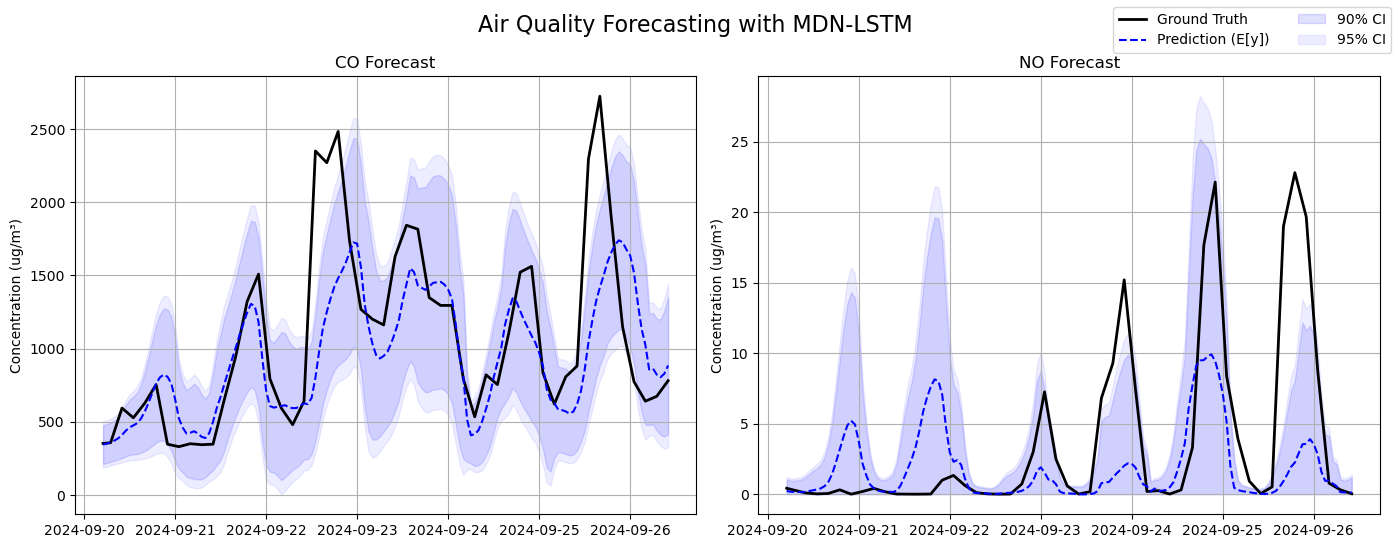

In [17]:

visualizer = MDNVisualizer(trainer)
visualizer.plot_timeseries_from_val(indeces=range(150), num_targets=2)
# visualizer.plot_mixture_distributions_at_timestep(timestep_index=29, num_targets=2)

# visualizer.generate_mixture_gif(start=0, end=48,num_targets=2, output_path="mixture_evolution.gif")

In [18]:
visualizer.generate_insights_from_timestep(timestep_index=13)

{'timestamp': Timestamp('2024-09-20 18:00:00+0000', tz='UTC'),
 'expected_values': [697.4477,
  2.2609138,
  19.31023,
  5.9684563,
  7.304725,
  14.863374,
  27.380623],
 'mixtures': {'mu': array([[ 5.68395872e+02,  9.13435126e-01,  1.39043217e+01,
           2.45859972e+01,  4.54668924e+00,  1.63359320e+01,
           2.84545219e+01],
         [ 9.20234145e+02,  5.00631130e+00,  2.52289671e+01,
           2.16408518e+00,  1.02069141e+01,  2.17239681e+01,
           3.71692136e+01],
         [ 1.74167094e+03,  1.62520434e+00,  5.23278210e+01,
           3.10202976e+01,  2.33581299e+01,  8.64535871e+01,
           1.12495716e+02],
         [ 5.60969638e+02,  7.80018681e-01,  1.64268789e+01,
           7.16169678e+00,  5.95875377e+00,  1.03878680e+01,
           2.15148310e+01],
         [ 6.83463897e+02,  5.58948672e-01, -4.60253316e+02,
           3.94716417e+01, -4.85020303e+02,  1.49870121e+01,
           2.68483978e+01],
         [ 4.59118117e+02,  4.92906429e-01,  1.23539856e+01,


### Choosing the Best Model

In [19]:
def lstm_mdn_objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
    step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])  # hours between timesteps
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    lookback_hours = lookback_days * 24

    training_dataset, validation_dataset = generate_datasets(
        dataset_df,
        lookback=lookback_hours,
        delay=24,   # predict 1 day ahead (constant)
        step=step
    )

    model = LSTM_MDN(
        input_dim=21,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_mixtures=num_mixtures,
        output_dim=7,
        dropout=dropout
        # fc_dim=fc_dim
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_pth = f"lstm_mdn_{trial.number}_checkpoint.pth"
    trainer = Trainer(
        model=model,
        criterion=mdn_loss,
        optimizer=optimizer,
        train_dataset=training_dataset,
        val_dataset=validation_dataset,
        model_pth=model_pth,
        batch_size=256
    )

    trainer.train(num_epochs=30)

    return trainer.history['val_loss'][-1]

lstm_study = optuna.create_study(
    direction="minimize",  # because lower NLL is better
    study_name="lstm_mdn_hyperparam_search",
    storage=f"sqlite:///{WEIGHTS_DIR}/optuna_study.db",
    load_if_exists=True
)


[I 2025-06-03 15:04:40,662] A new study created in RDB with name: lstm_mdn_hyperparam_search


In [20]:
lstm_study.optimize(lstm_mdn_objective, n_trials=30)

Validation: 100%|██████████| 219/219 [00:01<00:00, 214.42batch/s]


Epoch 1/30 - Train Loss: 2.861472 - Val Loss: -0.633744


Validation: 100%|██████████| 219/219 [00:01<00:00, 175.45batch/s]


Epoch 2/30 - Train Loss: -0.302455 - Val Loss: -1.076657


Validation: 100%|██████████| 219/219 [00:01<00:00, 215.69batch/s]


Epoch 3/30 - Train Loss: -0.902050 - Val Loss: -0.943677


Validation: 100%|██████████| 219/219 [00:01<00:00, 215.75batch/s]


Epoch 4/30 - Train Loss: -1.158445 - Val Loss: -1.826376


Validation: 100%|██████████| 219/219 [00:00<00:00, 223.71batch/s]


Epoch 5/30 - Train Loss: -1.568980 - Val Loss: -2.038904


Validation: 100%|██████████| 219/219 [00:01<00:00, 216.93batch/s]


Epoch 6/30 - Train Loss: -1.844895 - Val Loss: -2.281385


Validation: 100%|██████████| 219/219 [00:01<00:00, 215.64batch/s]


Epoch 7/30 - Train Loss: -2.035041 - Val Loss: -2.068005


Validation: 100%|██████████| 219/219 [00:01<00:00, 199.06batch/s]


Epoch 8/30 - Train Loss: -1.967497 - Val Loss: -2.316319


Validation: 100%|██████████| 219/219 [00:00<00:00, 239.16batch/s]


Epoch 9/30 - Train Loss: -2.366695 - Val Loss: -2.436362


Validation: 100%|██████████| 219/219 [00:00<00:00, 235.50batch/s]


Epoch 10/30 - Train Loss: -2.496853 - Val Loss: -1.944267


Validation: 100%|██████████| 219/219 [00:00<00:00, 236.84batch/s]


Epoch 11/30 - Train Loss: -2.632740 - Val Loss: -2.302467


Validation: 100%|██████████| 219/219 [00:01<00:00, 216.08batch/s]


Epoch 12/30 - Train Loss: -2.830798 - Val Loss: -2.004439


Validation: 100%|██████████| 219/219 [00:01<00:00, 173.96batch/s]


Epoch 13/30 - Train Loss: -2.597513 - Val Loss: -2.449757


Validation: 100%|██████████| 219/219 [00:01<00:00, 217.89batch/s]


Epoch 14/30 - Train Loss: -2.930451 - Val Loss: -1.561282


Validation: 100%|██████████| 219/219 [00:01<00:00, 200.26batch/s]


Epoch 15/30 - Train Loss: -2.915037 - Val Loss: -2.150074


Validation: 100%|██████████| 219/219 [00:01<00:00, 213.28batch/s]


Epoch 16/30 - Train Loss: -3.251573 - Val Loss: -2.452315


Validation: 100%|██████████| 219/219 [00:01<00:00, 213.78batch/s]


Epoch 17/30 - Train Loss: -3.379799 - Val Loss: -2.143825


Validation: 100%|██████████| 219/219 [00:01<00:00, 211.81batch/s]


Epoch 18/30 - Train Loss: -3.481373 - Val Loss: -2.204241


Validation: 100%|██████████| 219/219 [00:01<00:00, 215.14batch/s]


Epoch 19/30 - Train Loss: -3.603183 - Val Loss: -2.138634


Validation: 100%|██████████| 219/219 [00:01<00:00, 216.07batch/s]


Epoch 20/30 - Train Loss: -3.734164 - Val Loss: -1.980604


Validation: 100%|██████████| 219/219 [00:01<00:00, 215.08batch/s]


Epoch 21/30 - Train Loss: -3.839008 - Val Loss: -1.953702


Validation: 100%|██████████| 219/219 [00:01<00:00, 216.35batch/s]


Epoch 22/30 - Train Loss: -3.741126 - Val Loss: -2.102618


Validation: 100%|██████████| 219/219 [00:00<00:00, 233.55batch/s]


Epoch 23/30 - Train Loss: -3.977829 - Val Loss: -1.550960


Validation: 100%|██████████| 219/219 [00:01<00:00, 177.35batch/s]


Epoch 24/30 - Train Loss: -3.812056 - Val Loss: -1.970677


Validation: 100%|██████████| 219/219 [00:01<00:00, 216.44batch/s]


Epoch 25/30 - Train Loss: -4.044060 - Val Loss: -1.355012


Validation: 100%|██████████| 219/219 [00:01<00:00, 216.98batch/s]


Epoch 26/30 - Train Loss: -3.856361 - Val Loss: -1.623799


Validation: 100%|██████████| 219/219 [00:01<00:00, 172.95batch/s]


Epoch 27/30 - Train Loss: -1.654610 - Val Loss: -2.290892


Validation: 100%|██████████| 219/219 [00:01<00:00, 186.57batch/s]


Epoch 28/30 - Train Loss: -2.785607 - Val Loss: -2.480152


Validation: 100%|██████████| 219/219 [00:01<00:00, 168.01batch/s]


Epoch 29/30 - Train Loss: -3.432521 - Val Loss: -2.144283


Validation: 100%|██████████| 219/219 [00:00<00:00, 230.66batch/s]


Epoch 30/30 - Train Loss: -3.675088 - Val Loss: -1.913086


[I 2025-06-03 15:10:46,037] Trial 0 finished with value: -1.9130858600683953 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'num_mixtures': 3, 'lr': 0.0012072723310861178, 'lookback_days': 1, 'step': 6, 'dropout': 0.4052774632907246}. Best is trial 0 with value: -1.9130858600683953.
Validation: 100%|██████████| 217/217 [00:00<00:00, 256.89batch/s]


Epoch 1/30 - Train Loss: 2.544518 - Val Loss: 1.918055


Validation: 100%|██████████| 217/217 [00:00<00:00, 251.33batch/s]


Epoch 2/30 - Train Loss: 0.368932 - Val Loss: -0.886666


Validation: 100%|██████████| 217/217 [00:00<00:00, 280.50batch/s]


Epoch 3/30 - Train Loss: -0.423900 - Val Loss: -1.075409


Validation: 100%|██████████| 217/217 [00:00<00:00, 239.43batch/s]


Epoch 4/30 - Train Loss: -1.250639 - Val Loss: -2.384302


Validation: 100%|██████████| 217/217 [00:01<00:00, 155.68batch/s]


Epoch 5/30 - Train Loss: -1.901996 - Val Loss: -2.667919


Validation: 100%|██████████| 217/217 [00:00<00:00, 278.82batch/s]


Epoch 6/30 - Train Loss: -2.079878 - Val Loss: -2.645274


Validation: 100%|██████████| 217/217 [00:00<00:00, 283.58batch/s]


Epoch 7/30 - Train Loss: -2.193102 - Val Loss: -2.846427


Validation: 100%|██████████| 217/217 [00:00<00:00, 252.86batch/s]


Epoch 8/30 - Train Loss: -2.346455 - Val Loss: -2.994785


Validation: 100%|██████████| 217/217 [00:00<00:00, 244.06batch/s]


Epoch 9/30 - Train Loss: -2.538407 - Val Loss: -3.067349


Validation: 100%|██████████| 217/217 [00:00<00:00, 256.73batch/s]


Epoch 10/30 - Train Loss: -2.654461 - Val Loss: -3.205357


Validation: 100%|██████████| 217/217 [00:00<00:00, 255.30batch/s]


Epoch 11/30 - Train Loss: -2.752815 - Val Loss: -3.319011


Validation: 100%|██████████| 217/217 [00:00<00:00, 250.84batch/s]


Epoch 12/30 - Train Loss: -2.903679 - Val Loss: -3.398461


Validation: 100%|██████████| 217/217 [00:00<00:00, 244.06batch/s]


Epoch 13/30 - Train Loss: -3.040603 - Val Loss: -3.508523


Validation: 100%|██████████| 217/217 [00:00<00:00, 288.52batch/s]


Epoch 14/30 - Train Loss: -3.173294 - Val Loss: -3.567632


Validation: 100%|██████████| 217/217 [00:00<00:00, 245.29batch/s]


Epoch 15/30 - Train Loss: -3.250053 - Val Loss: -3.540425


Validation: 100%|██████████| 217/217 [00:01<00:00, 172.71batch/s]


Epoch 16/30 - Train Loss: -3.313446 - Val Loss: -3.513601


Validation: 100%|██████████| 217/217 [00:00<00:00, 256.46batch/s]


Epoch 17/30 - Train Loss: -3.407451 - Val Loss: -3.563892


Validation: 100%|██████████| 217/217 [00:00<00:00, 278.80batch/s]


Epoch 18/30 - Train Loss: -3.433654 - Val Loss: -3.621818


Validation: 100%|██████████| 217/217 [00:00<00:00, 260.46batch/s]


Epoch 19/30 - Train Loss: -3.459298 - Val Loss: -3.580882


Validation: 100%|██████████| 217/217 [00:00<00:00, 273.27batch/s]


Epoch 20/30 - Train Loss: -3.521356 - Val Loss: -3.625904


Validation: 100%|██████████| 217/217 [00:00<00:00, 246.10batch/s]


Epoch 21/30 - Train Loss: -3.558330 - Val Loss: -3.645506


Validation: 100%|██████████| 217/217 [00:00<00:00, 277.53batch/s]


Epoch 22/30 - Train Loss: -3.604904 - Val Loss: -3.545322


Validation: 100%|██████████| 217/217 [00:01<00:00, 175.80batch/s]


Epoch 23/30 - Train Loss: -3.619013 - Val Loss: -3.590791


Validation: 100%|██████████| 217/217 [00:00<00:00, 230.43batch/s]


Epoch 24/30 - Train Loss: -3.663605 - Val Loss: -3.507202


Validation: 100%|██████████| 217/217 [00:00<00:00, 273.18batch/s]


Epoch 25/30 - Train Loss: -3.698485 - Val Loss: -3.627159


Validation: 100%|██████████| 217/217 [00:00<00:00, 258.88batch/s]


Epoch 26/30 - Train Loss: -3.716216 - Val Loss: -3.736176


Validation: 100%|██████████| 217/217 [00:01<00:00, 177.94batch/s]


Epoch 27/30 - Train Loss: -3.728626 - Val Loss: -3.503715


Validation: 100%|██████████| 217/217 [00:00<00:00, 236.37batch/s]


Epoch 28/30 - Train Loss: -3.774739 - Val Loss: -3.551855


Validation: 100%|██████████| 217/217 [00:00<00:00, 269.05batch/s]


Epoch 29/30 - Train Loss: -3.824664 - Val Loss: -3.548889


Validation: 100%|██████████| 217/217 [00:00<00:00, 272.54batch/s]


Epoch 30/30 - Train Loss: -3.830366 - Val Loss: -3.572104


[I 2025-06-03 15:17:05,795] Trial 1 finished with value: -3.5721042770119857 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'num_mixtures': 7, 'lr': 0.008580115787203784, 'lookback_days': 2, 'step': 3, 'dropout': 0.4966477704779986}. Best is trial 1 with value: -3.5721042770119857.
 38%|███▊      | 1590/4225 [00:01<00:02, 1137.65it/s]
[W 2025-06-03 15:17:14,094] Trial 2 failed with parameters: {'hidden_dim': 128, 'num_layers': 1, 'num_mixtures': 8, 'lr': 0.003817439080872239, 'lookback_days': 4, 'step': 3, 'dropout': 0.22410568377281165} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/msds2025/fcayco/.local/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_585/120408768.py", line 12, in lstm_mdn_objective
    training_dataset, validation_dataset = generate_datasets(
                                          

KeyboardInterrupt: 

In [ ]:
lstm_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_lookback_days,params_lr,params_num_layers,params_num_mixtures,params_step,state
0,0,NaN,2025-06-03 01:50:29.985633,2025-06-03 01:50:30.897941,0 days 00:00:00.912308,0.269445,64,4,0.000513,2,8,1,FAIL
1,1,-3.471561,2025-06-03 01:50:58.575736,2025-06-03 01:55:32.898710,0 days 00:04:34.322974,0.199885,128,2,0.000143,2,7,4,COMPLETE
2,2,-0.824970,2025-06-03 01:55:32.909750,2025-06-03 02:03:10.734871,0 days 00:07:37.825121,0.416878,256,2,0.000478,3,4,6,COMPLETE
3,3,11.117490,2025-06-03 02:03:10.743520,2025-06-03 02:18:19.618048,0 days 00:15:08.874528,0.136502,256,4,0.000370,2,6,3,COMPLETE
4,4,-1.089620,2025-06-03 02:18:19.642022,2025-06-03 02:22:17.066919,0 days 00:03:57.424897,0.073563,128,1,0.000778,2,7,3,COMPLETE
5,5,NaN,2025-06-03 02:22:17.073864,2025-06-03 02:22:42.388236,0 days 00:00:25.314372,0.408811,128,1,0.000459,3,7,6,FAIL
6,6,-1.877041,2025-06-03 02:33:13.049517,2025-06-03 02:37:06.415733,0 days 00:03:53.366216,0.150628,256,1,0.000212,1,5,4,COMPLETE
7,7,NaN,2025-06-03 02:37:06.425694,2025-06-03 02:37:36.059975,0 days 00:00:29.634281,0.023302,256,2,0.006770,1,7,1,FAIL
8,8,NaN,2025-06-03 02:45:08.180984,2025-06-03 02:45:11.442764,0 days 00:00:03.261780,0.006253,256,4,0.002918,2,8,4,FAIL
9,9,-2.407743,2025-06-03 03:03:15.080446,2025-06-03 03:13:45.117967,0 days 00:10:30.037521,0.230481,256,2,0.005585,2,3,2,COMPLETE


In [ ]:
class GRU_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_mixtures, output_dim, dropout=0.3):
        super(GRU_MDN, self).__init__()
        self.num_mixtures = num_mixtures
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = gru_out[:, -1, :]  # Use last timestep

        h = self.fc(last_output)
        h = self.batch_norm(h)
        h = F.relu(h)
        h = self.dropout(h)

        mu, sigma, alpha = self.mdn(h)
        return mu, sigma, alpha

In [ ]:
def gru_mdn_objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
    step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])  # hours between timesteps
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    lookback_hours = lookback_days * 24

    training_dataset, validation_dataset = generate_datasets(
        dataset_df,
        lookback=lookback_hours,
        delay=24,  # 1-day ahead prediction
        step=step
    )

    model = GRU_MDN(
        input_dim=21,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_mixtures=num_mixtures,
        output_dim=7,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_pth = f"gru_mdn_{trial.number}_checkpoint.pth"
    trainer = Trainer(
        model=model,
        criterion=mdn_loss,
        optimizer=optimizer,
        train_dataset=training_dataset,
        val_dataset=validation_dataset,
        model_pth=model_pth,
        batch_size=256
    )

    trainer.train(num_epochs=30)

    return trainer.history['val_loss'][-1]

gru_study = optuna.create_study(
    direction="minimize",
    study_name="gru_mdn_hyperparam_search",
    storage=f"sqlite:///{WEIGHTS_DIR}/optuna_study.db",
    load_if_exists=True
)


[I 2025-06-03 14:53:17,745] Using an existing study with name 'gru_mdn_hyperparam_search' instead of creating a new one.


In [ ]:
gru_study.optimize(gru_mdn_objective, n_trials=30)

In [ ]:
class RNN_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_mixtures, output_dim, dropout=0.3):
        super(RNN_MDN, self).__init__()
        self.num_mixtures = num_mixtures
        self.hidden_dim = hidden_dim

        self.rnn = nn.RNN(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_output = rnn_out[:, -1, :]  # Last time step

        h = self.fc(last_output)
        h = self.batch_norm(h)
        h = F.relu(h)
        h = self.dropout(h)

        mu, sigma, alpha = self.mdn(h)
        return mu, sigma, alpha

In [21]:
def rnn_mdn_objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
    step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])  # hours between timesteps
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    lookback_hours = lookback_days * 24

    training_dataset, validation_dataset = generate_datasets(
        dataset_df,
        lookback=lookback_hours,
        delay=24,  # 1-day ahead forecast
        step=step
    )

    model = RNN_MDN(
        input_dim=21,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_mixtures=num_mixtures,
        output_dim=7,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_pth = f"rnn_mdn_{trial.number}_checkpoint.pth"
    trainer = Trainer(
        model=model,
        criterion=mdn_loss,
        optimizer=optimizer,
        train_dataset=training_dataset,
        val_dataset=validation_dataset,
        model_pth=model_pth,
        batch_size=256
    )

    trainer.train(num_epochs=30)

    return trainer.history['val_loss'][-1]

rnn_study = optuna.create_study(
    direction="minimize",
    study_name="rnn_mdn_hyperparam_search",
    storage=f"sqlite:///{WEIGHTS_DIR}/optuna_study.db",
    load_if_exists=True
)

[I 2025-06-03 15:17:57,945] A new study created in RDB with name: rnn_mdn_hyperparam_search


In [22]:
rnn_study.optimize(rnn_mdn_objective, n_trials=30)

Validation: 100%|██████████| 219/219 [00:01<00:00, 216.23batch/s]


Epoch 1/30 - Train Loss: 2.316952 - Val Loss: -2.147511


Validation: 100%|██████████| 219/219 [00:00<00:00, 223.00batch/s]


Epoch 2/30 - Train Loss: -1.879709 - Val Loss: -1.715726


Validation: 100%|██████████| 219/219 [00:00<00:00, 237.30batch/s]


Epoch 3/30 - Train Loss: -2.326363 - Val Loss: -2.932033


Epoch 4:  57%|█████▋    | 216/381 [00:03<00:02, 55.50batch/s]
[W 2025-06-03 15:20:24,254] Trial 0 failed with parameters: {'hidden_dim': 256, 'num_layers': 2, 'num_mixtures': 8, 'lr': 0.0008696742701330395, 'lookback_days': 1, 'step': 4, 'dropout': 0.44931621028042995} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/tmp/ipykernel_585/1483776821.py", line 45, in train
    for inputs, targets  in tqdm(self.train_loader, desc=f"Epoch {epoch+1}", unit="batch"):
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
               ^^^^^^^^
  File "/home/msds2025/fcayco/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/home/msds2025/fcayco/.local/lib/python3.12/site-packages/torch/utils/data/da


🛑 Training interrupted by user. Saving checkpoint...
✅ Saved model to /mnt/processed/private/msds2025/cpt3/ml3/finalproject/weights/rnn_mdn_0_checkpoint.pth at epoch 4


KeyboardInterrupt: 

In [26]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size, padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)

class TCN_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_mixtures, output_dim, num_layers=4):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(
                TCNBlock(
                    in_channels=input_dim if i == 0 else hidden_dim,
                    out_channels=hidden_dim,
                    kernel_size=3,
                    dilation=2**i
                )
            )

        self.num_mixtures = num_mixtures
        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):  # x: (B, T, F)
        x = x.permute(0, 2, 1)  # (B, F, T)
        x = self.tcn(x)
        x = self.global_pool(x).squeeze(-1)  # (B, hidden_dim)
        return self.mdn(x)

In [27]:
def tcn_mdn_objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 2, 5)
    num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
    step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    lookback_hours = lookback_days * 24

    training_dataset, validation_dataset = generate_datasets(
        dataset_df,
        lookback=lookback_hours,
        delay=24,  # 1-day ahead prediction
        step=step
    )

    model = TCN_MDN(
        input_dim=21,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_mixtures=num_mixtures,
        output_dim=7,
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_pth = f"tcn_mdn_{trial.number}_checkpoint.pth"
    trainer = Trainer(
        model=model,
        criterion=mdn_loss,
        optimizer=optimizer,
        train_dataset=training_dataset,
        val_dataset=validation_dataset,
        model_pth=model_pth,
        batch_size=256
    )

    trainer.train(num_epochs=30)

    return trainer.history['val_loss'][-1]

In [28]:
tcn_study = optuna.create_study(
    direction="minimize",
    study_name="tcn_mdn_hyperparam_search",
    storage=f"sqlite:///{WEIGHTS_DIR}/optuna_study.db",
    load_if_exists=True
)
tcn_study.optimize(tcn_mdn_objective, n_trials=30)

[I 2025-06-03 15:21:30,604] Using an existing study with name 'tcn_mdn_hyperparam_search' instead of creating a new one.
Validation: 100%|██████████| 217/217 [00:01<00:00, 121.85batch/s]


Epoch 1/30 - Train Loss: -1.344916 - Val Loss: -2.433040


Validation: 100%|██████████| 217/217 [00:00<00:00, 217.13batch/s]


Epoch 2/30 - Train Loss: -3.729200 - Val Loss: -2.586131


Epoch 3:  68%|██████▊   | 256/379 [00:04<00:01, 63.70batch/s]
[W 2025-06-03 15:23:32,176] Trial 1 failed with parameters: {'hidden_dim': 256, 'num_layers': 3, 'num_mixtures': 6, 'lr': 0.00034418440190853633, 'lookback_days': 2, 'step': 2, 'dropout': 0.16181533837362666} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/tmp/ipykernel_585/1483776821.py", line 54, in train
    loss = self.criterion(targets, mu, sigma, alpha, self.model.num_mixtures)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_585/3679901629.py", line 17, in mdn_loss
    log_probs = normal.log_prob(y)  # [batch, num_mixtures, output_dim]
                ^^^^^^^^^^^^^^^^^^
  File "/home/msds2025/fcayco/.local/lib/python3.12/site-packages/torch/distributions/normal.py", line 82, in log_prob
    self._validate_sample(value)
  File "/home/msds2025/fcayco/.local/lib/python3.12/site-packages/torch/distributions/distribution.py


🛑 Training interrupted by user. Saving checkpoint...
✅ Saved model to /mnt/processed/private/msds2025/cpt3/ml3/finalproject/weights/tcn_mdn_1_checkpoint.pth at epoch 3


KeyboardInterrupt: 

In [33]:
class Transformer_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, num_mixtures, output_dim, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True
        )

        self.num_mixtures = num_mixtures
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):  # (B, T, F)
        x = self.input_proj(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # average pooling over time
        return self.mdn(x)

In [34]:
def transformer_mdn_objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
    step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])

    lookback_hours = lookback_days * 24

    training_dataset, validation_dataset = generate_datasets(
        dataset_df,
        lookback=lookback_hours,
        delay=24,  # predict 1 day ahead
        step=step
    )

    model = Transformer_MDN(
        input_dim=21,
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        num_mixtures=num_mixtures,
        output_dim=7,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_pth = f"transformer_mdn_{trial.number}_checkpoint.pth"
    trainer = Trainer(
        model=model,
        criterion=mdn_loss,
        optimizer=optimizer,
        train_dataset=training_dataset,
        val_dataset=validation_dataset,
        model_pth=model_pth,
        batch_size=256
    )

    trainer.train(num_epochs=30)

    return trainer.history['val_loss'][-1]

In [ ]:
transformer_study = optuna.create_study(
    direction="minimize",
    study_name="transformer_mdn_hyperparam_search",
    storage=f"sqlite:///{WEIGHTS_DIR}/optuna_study.db",
    load_if_exists=True
)
transformer_study.optimize(transformer_mdn_objective, n_trials=30)

[I 2025-06-03 15:25:55,872] Using an existing study with name 'transformer_mdn_hyperparam_search' instead of creating a new one.
Validation: 100%|██████████| 215/215 [00:01<00:00, 125.20batch/s]


Epoch 1/30 - Train Loss: 1.387886 - Val Loss: -0.894028


Validation: 100%|██████████| 215/215 [00:00<00:00, 226.32batch/s]


Epoch 2/30 - Train Loss: -0.890827 - Val Loss: -1.492693


Validation: 100%|██████████| 215/215 [00:01<00:00, 205.63batch/s]


Epoch 3/30 - Train Loss: -1.316013 - Val Loss: -1.548856


Validation: 100%|██████████| 215/215 [00:01<00:00, 195.33batch/s]


Epoch 4/30 - Train Loss: -1.536002 - Val Loss: -1.576188


Validation: 100%|██████████| 215/215 [00:01<00:00, 189.49batch/s]


Epoch 5/30 - Train Loss: -1.682162 - Val Loss: -1.668629


Validation: 100%|██████████| 215/215 [00:01<00:00, 193.61batch/s]


Epoch 6/30 - Train Loss: -1.806644 - Val Loss: -1.636861


Validation: 100%|██████████| 215/215 [00:00<00:00, 221.97batch/s]


Epoch 7/30 - Train Loss: -1.893159 - Val Loss: -1.732961


Validation: 100%|██████████| 215/215 [00:00<00:00, 220.00batch/s]


Epoch 8/30 - Train Loss: -1.974587 - Val Loss: -1.653945


Validation: 100%|██████████| 215/215 [00:01<00:00, 201.03batch/s]


Epoch 9/30 - Train Loss: -2.048742 - Val Loss: -1.600762


Validation: 100%|██████████| 215/215 [00:00<00:00, 222.16batch/s]


Epoch 10/30 - Train Loss: -2.112903 - Val Loss: -1.479978


Validation: 100%|██████████| 215/215 [00:00<00:00, 216.20batch/s]


Epoch 11/30 - Train Loss: -2.180969 - Val Loss: -1.577589


Validation: 100%|██████████| 215/215 [00:01<00:00, 213.84batch/s]


Epoch 12/30 - Train Loss: -2.241639 - Val Loss: -1.560841


Validation: 100%|██████████| 215/215 [00:00<00:00, 217.65batch/s]


Epoch 13/30 - Train Loss: -2.294576 - Val Loss: -1.526537


Validation: 100%|██████████| 215/215 [00:00<00:00, 241.63batch/s]


Epoch 14/30 - Train Loss: -2.338577 - Val Loss: -1.443903


Validation: 100%|██████████| 215/215 [00:00<00:00, 218.89batch/s]


Epoch 15/30 - Train Loss: -2.381196 - Val Loss: -1.178399


Validation: 100%|██████████| 215/215 [00:00<00:00, 235.57batch/s]


Epoch 16/30 - Train Loss: -2.422865 - Val Loss: -1.401250


Validation: 100%|██████████| 215/215 [00:00<00:00, 218.18batch/s]


Epoch 17/30 - Train Loss: -2.465440 - Val Loss: -1.471559


Validation: 100%|██████████| 215/215 [00:01<00:00, 203.61batch/s]


Epoch 18/30 - Train Loss: -2.491755 - Val Loss: -1.402634


Validation: 100%|██████████| 215/215 [00:00<00:00, 244.86batch/s]


Epoch 19/30 - Train Loss: -2.544486 - Val Loss: -1.281331


Validation: 100%|██████████| 215/215 [00:00<00:00, 222.48batch/s]


Epoch 20/30 - Train Loss: -2.577776 - Val Loss: -1.210566


Validation: 100%|██████████| 215/215 [00:01<00:00, 196.48batch/s]


Epoch 21/30 - Train Loss: -2.611676 - Val Loss: -1.172626


Validation: 100%|██████████| 215/215 [00:01<00:00, 214.57batch/s]


Epoch 22/30 - Train Loss: -2.661499 - Val Loss: -1.177321


Validation: 100%|██████████| 215/215 [00:00<00:00, 219.20batch/s]


Epoch 23/30 - Train Loss: -2.703015 - Val Loss: -1.150310


Validation: 100%|██████████| 215/215 [00:01<00:00, 213.68batch/s]


Epoch 24/30 - Train Loss: -2.732659 - Val Loss: -1.066287


Validation: 100%|██████████| 215/215 [00:00<00:00, 217.47batch/s]


Epoch 25/30 - Train Loss: -2.762535 - Val Loss: -0.729731


Validation: 100%|██████████| 215/215 [00:00<00:00, 216.81batch/s]


Epoch 26/30 - Train Loss: -2.796813 - Val Loss: -1.178509


Validation: 100%|██████████| 215/215 [00:00<00:00, 220.72batch/s]


Epoch 27/30 - Train Loss: -2.821506 - Val Loss: -0.891501


Validation: 100%|██████████| 215/215 [00:00<00:00, 236.60batch/s]


Epoch 28/30 - Train Loss: -2.880085 - Val Loss: -1.017435


Validation: 100%|██████████| 215/215 [00:00<00:00, 220.90batch/s]


Epoch 29/30 - Train Loss: -2.905529 - Val Loss: -0.993802


Validation: 100%|██████████| 215/215 [00:00<00:00, 215.28batch/s]
[I 2025-06-03 15:35:06,742] Trial 1 finished with value: -0.9071690570476443 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'num_heads': 4, 'num_mixtures': 4, 'lr': 0.00015328135127349324, 'dropout': 0.03831265861261829, 'lookback_days': 4, 'step': 4}. Best is trial 1 with value: -0.9071690570476443.


Epoch 30/30 - Train Loss: -2.944923 - Val Loss: -0.907169


 75%|███████▌  | 5600/7461 [00:03<00:01, 1629.18it/s]